In [1]:
import os
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from samplers import get_data_sampler, sample_transformation
from tasks import get_task_sampler
from models import LeastSquaresModel
from matplotlib.ticker import MaxNLocator

import numpy as np
from scipy.signal import savgol_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'whitegrid')
palette = sns.color_palette('colorblind')

In [2]:
run_dir = "/Users/harmonbhasin/College/Research/huLab/final_code/curriculum_learning_icl/models"
df = read_run_dir(run_dir)

In [3]:
def run_evaluation(subset_models, task_args, data_args, seed, att_mask=None):
    models = {}
    configs = {}
    n_points = 100
    n_dims = 20
    b_size = 64

    for key in subset_models:
        task = df.task[subset_models[key]]
        run_id = df.run_id[subset_models[key]]
        run_path = os.path.join(run_dir, task, run_id)
        models[key], configs[key] = get_model_from_run(run_path)

    preDict = {}
    yDict = {}

    for task_key in task_args:
        current_task = task_args[task_key]
        task_sampler = get_task_sampler(
            current_task['task'],
            n_dims,
            b_size,
            **{i: current_task[i] for i in current_task if i != 'task'}
        )
        print('Conducting evaluation on', current_task['task'], 'with degree of ', current_task['degree'], '\n')
        for data_key in data_args:
            torch.manual_seed(seed)
            current_data = data_args[data_key]
            sample_args = {}

            if current_data['type'] == 'Skewed':
                eigenvals = 1 / (torch.arange(n_dims) + 1)
                scale = sample_transformation(eigenvals, normalize=True)
                sample_args['scale'] = scale

            for data_info in current_data:
                if data_info != 'data' and data_info != 'type':
                    sample_args[data_info] = current_data[data_info]

            data_sampler = get_data_sampler(current_data['data'], n_dims, **sample_args)

            # Create an instance of the function class sampler; add seed stuff here
            task = task_sampler()

            # Generate x points; add seed stuff here
            xs = data_sampler.sample_xs(n_points, b_size)

            # Generate y points
            ys = task.evaluate(xs)

            yDict[f"{task_key}_{data_key}"] = ys

            for model_key in models:
                prompt_col = 0
                prompt_row = 0
                conf = configs[model_key]['training']
                prompt_args = conf['prompt_kwargs']
                if len(prompt_args) != 0:
                       if prompt_args['type'] == 'data':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(data_key[-1])
                           prompt_col = prompt_args['position']
                       elif prompt_args['type'] == 'task':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(task_key[-1])
                           prompt_col = prompt_args['position']

                temp_key = f"{model_key}_{task_key}_{data_key}"
                with torch.no_grad():
                    if att_mask is None:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col)
                    else:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col,
                                                            att_mask=att_mask)

                    if conf['prompt_type'] == 'standard':
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution')
                    else:
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution with instruction in row', prompt_row, 'and column', prompt_col)
    lossDict = {}
    for pred_key in preDict:
        for y_key in yDict:
            if y_key in pred_key:
                lossDict[pred_key] = (yDict[y_key] - preDict[pred_key]).square().numpy()

    different_plots = {}

    for key in lossDict:
        components = key.split('_')
        model = components[0]
        task = components[1]
        data = components[2]
        task_data = f"{task}_{data}"
        if task_data not in different_plots:
            different_plots[task_data] = {}
        different_plots[task_data][model] = lossDict[key]

    return different_plots, configs

In [4]:
def figure_mixed_plot_results_horizontal(different_plots, configs, task_args, data_args, type, head_dir, smooth, window_size = 10, limit_y=False, y_lim_low=[-0.1,-0.1, -0.1], y_lim_high=[1.0,1.0,1.0], width=12,height=4, legend=False, title=None, name = None):
    task_num = len(task_args)
    data_num = len(data_args)

    sns.set_palette("RdYlBu")
    color_index = 0
    for key in configs:
        if 'Mixed' in configs[key]['wandb']['name']:
            configs[key]['name'] = 'Mixed model'
        elif 'Random' in configs[key]['wandb']['name']:
            configs[key]['name'] = 'Random model'
        elif 'Sequential' in configs[key]['wandb']['name']:
            configs[key]['name'] = 'Sequential model'


        configs[key]['c'] = sns.color_palette()[color_index]
        color_index +=1

    if type == 'task':
        #_, axs = plt.subplots(nrows=1, ncols=task_num, figsize=(width,height), tight_layout=True)
        _, axs = plt.subplots(nrows=1, ncols=1, figsize=(width,height))
    else:
        _, axs = plt.subplots(nrows=1, ncols=data_num, figsize=(width,height), tight_layout=True)

    if type == 'task':
        #for i in range(task_num):
        #    for j in range(data_num):
        i=1
        j=0
        current_task = f"task{i}"
        current_data = f"data{j}"
        current_eval = different_plots[f"{current_task}_{current_data}"]
        for key in current_eval:
            if smooth:
                # Moving average via ChatGPT
                smoothed_data = np.convolve(current_eval[key].mean(axis=0)/20, np.ones((window_size,))/window_size, mode='valid')
                axs.plot(smoothed_data,
                                lw=1,
                                label=f"{configs[key]['name']}",
                                color=configs[key]['c'])
            else:
                axs.plot(current_eval[key].mean(axis=0)/20,
                                lw=1,
                                label=configs[key]['name'],
                                color='black')
            if limit_y:
                axs.set_ylim(y_lim_low[i,j],y_lim_high[i,j])
    else:
        for i in range(data_num):
            for j in range(task_num):
                current_task = f"task{j}"
                current_data = f"data{i}"
                current_eval = different_plots[f"{current_task}_{current_data}"]
                for key in current_eval:
                    axs[i].plot(current_eval[key].mean(axis=0),
                                    lw=3,
                                    label=configs[key]['name'],
                                    color='black')

                    if limit_y:
                        axs[i].set_ylim(y_lim_low[i,j],y_lim_high[i,j])

    axs.set_ylabel("Normalized MSE", fontname='Times New Roman', fontsize=10)

    axs.xaxis.set_major_locator(plt.MultipleLocator(10))
    axs.set_ylim(0,20)
    #axs.yaxis.set_major_locator(plt.MultipleLocator(3))
    #ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune='both'))
    #ax.tick_params(axis='x', rotation=90)
    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontname('Times New Roman')
        label.set_fontsize(10)
    axs.set_xlabel("# in-context examples", fontname='Times New Roman', fontsize=10)
    if legend:
        #axs.legend(prop={'family': 'Times New Roman', 'size': 10}, loc='center right', bbox_to_anchor=(1, 2), frameon=True, ncol=2)
        axs.legend(prop={'family': 'Times New Roman', 'size': 10}, loc='center right', bbox_to_anchor=(1, 2), frameon=True)

    if title != None:
        plt.figtext(0.5, 0.925, title, ha='center', fontname='Times New Roman', fontsize=12, fontweight='bold')


    #if name == None:
    #    plt.savefig(f"{head_dir}/eval_{configs[key]['wandb']['name']}.pdf", bbox_inches='tight')
    #else:
    #    plt.savefig(f"{head_dir}/{name}.pdf", bbox_inches='tight')

In [5]:
df

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
5,65ac84ab-0032-48f5-8e5b-62f73bbe1c0a,model_11_gaussian,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Gaussian (Model Three)
19,056f3269-57f0-4f23-81a1-f41a986cc220,model_12_binomial,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial
15,d5ef58bd-d57d-4d1f-bb08-66faeb4b6e3f,model_14_binomial_seed_0,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial (Seed = 0)
12,91c6983a-f8c4-4640-bf45-898508df0758,model_14_binomial_seed_1,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial (Seed = 1)
2,3f2f4a8f-6337-4ec3-8410-2f2192dd221b,model_14_binomial_seed_2,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial (Seed = 2)
7,55309b22-4e45-43f3-8a25-59500a9250ec,model_14_binomial_seed_3,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial (Seed = 3)
6,b3dfd265-786b-4700-bb16-28a196ff5fd2,model_14_binomial_seed_4,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial (Seed = 4)
8,4f0209b2-57b0-42c0-9c1f-2d5de79e4d2e,model_12_trinomial,Transformer,"task_0=Munch({'degree': 3, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Trinomial
14,78f9aced-e257-4fec-81cd-c95fb94bd31c,model_14_mixed_multi_task_model_seed_0,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Mixed Curriculum (Seed = 0)
16,6d0ce941-21b5-4b82-881b-f5e2f9f58846,model_14_mixed_multi_task_model_seed_1,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Mixed Curriculum (Seed = 1)


In [6]:
index = 0
model_selection = {}
model_to_name = {}
for task_name in df.task:
    if "model_12" in task_name and ("random" in task_name or "mixed" in task_name or "sequential" in task_name) and "_i" not in task_name:
        task_index = df.loc[df["task"] == task_name].index[0]
        model_selection[f'model{index}'] = task_index
        print(f"model{index}:", task_name)
        model_to_name[f"model{index}"] = task_name
        index+=1

model0: model_12_mixed_multi_task_model
model1: model_12_random_multi_task_model
model2: model_12_sequential_multi_task_model


In [7]:
model_selection

{'model0': 3, 'model1': 9, 'model2': 18}

In [8]:
task_args = {'task0': {'task': "hermite_regression", 'degree': 1},
             'task1': {'task': "hermite_regression", 'degree': 2},
             'task2': {'task': "hermite_regression", 'degree': 3}}

data_args = {'data0': {'data': 'gaussian', 'type': 'Standard'}}
seed=-152

In [9]:
different_plots, configs = run_evaluation(subset_models=model_selection,
                   task_args=task_args,
                   data_args=data_args,
                   seed=seed)

Conducting evaluation on hermite_regression with degree of  1 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Random Hermite Polynomial evaluated on Standard gaussian distribution
Sequential Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  2 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Random Hermite Polynomial evaluated on Standard gaussian distribution
Sequential Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  3 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Random Hermite Polynomial evaluated on Standard gaussian distribution
Sequential Hermite Polynomial evaluated on Standard gaussian distribution


In [10]:
eval_calculations = copy.deepcopy(different_plots)
changeable_config = copy.deepcopy(configs)

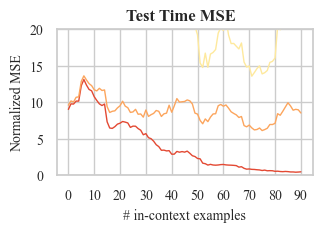

In [11]:
head_dir="/Users/harmonbhasin/College/Research/huLab/paper_figures/task_mask"
figure_mixed_plot_results_horizontal(different_plots=eval_calculations, 
                        configs=changeable_config, 
                        task_args=task_args, 
                        data_args=data_args, 
                        type = 'task', 
                        head_dir=head_dir, 
                        smooth=True,
                        width=3.3,
                        height=1.9,
                        legend=False,
                        name='mixed_best', 
                        title = 'Test Time MSE')

#width=3.3,
#height=1.9,